In [1]:
from obspy import read
import numpy as np
from obspy.signal.trigger import recursive_sta_lta, classic_sta_lta, trigger_onset, plot_trigger
from obspy.signal.trigger import ar_pick
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

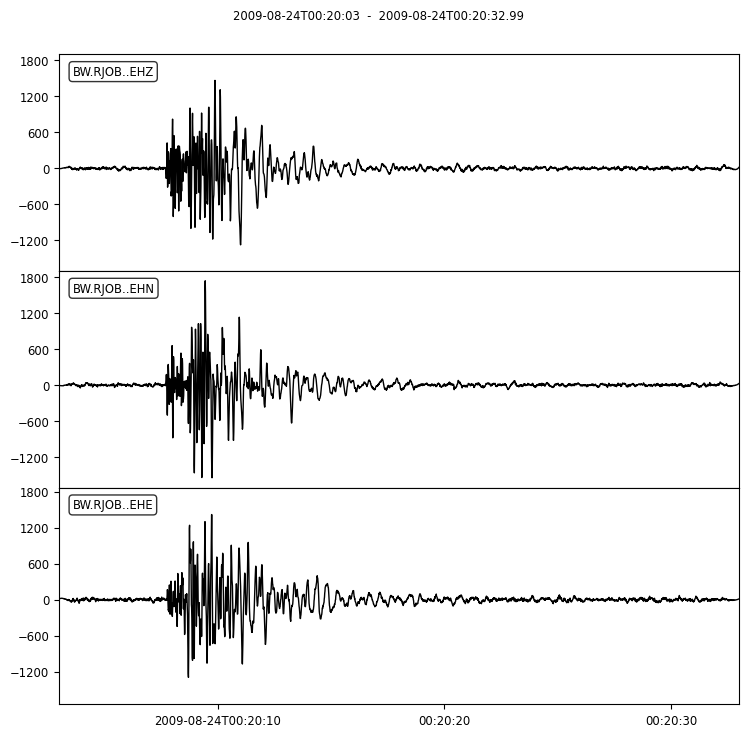

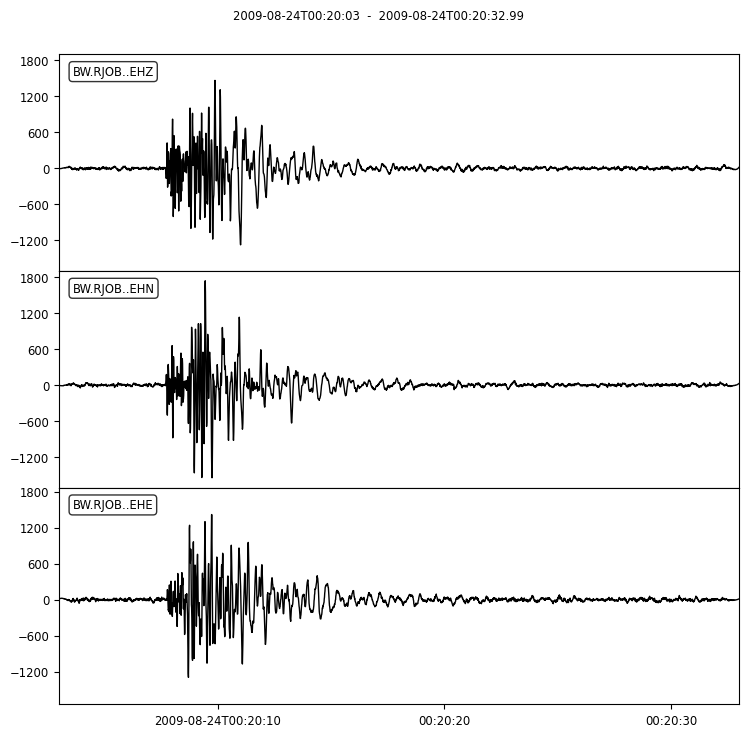

In [2]:
# read, detrend, filter
stream = read('BW.RJOB.2009.08.mseed')
stream_filt = stream.copy()
stream_filt.detrend(type='demean')
stream_filt.filter('highpass', freq=1, corners=2, zerophase=True)
stream_filt.plot()

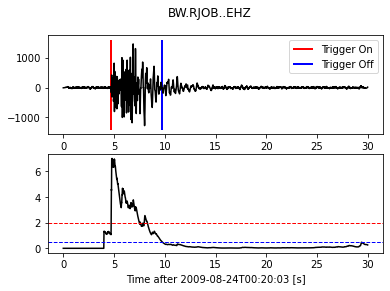

[[472 974]]
2009-08-24T00:20:07.680000Z 2009-08-24T00:20:09.390000Z


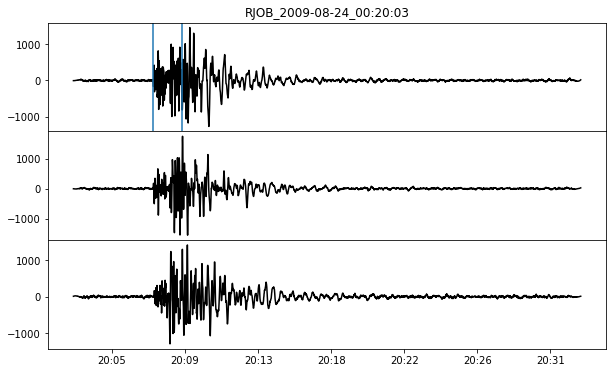

In [3]:

# Determine component of the channel
for i in range(len(stream_filt)):
    if stream_filt[i].stats.channel[2] == 'E':
        ECOM = stream_filt[i]
    elif stream_filt[i].stats.channel[2] == 'N':
        NCOM = stream_filt[i]
    else:
        ZCOM = stream_filt[i]


# STATS data, delta time and sampling rate
station = ZCOM.stats.station
dt = ZCOM.stats.delta
sr = ZCOM.stats.sampling_rate
start = ZCOM.stats.starttime
npts = ZCOM.stats.npts
time = ZCOM.times()

# STA LTA, trigger
nsta = 0.5
nlta = 4
rec = recursive_sta_lta(ZCOM.data, int(nsta * sr), int(nlta * sr))
# cls = classic_sta_lta(ZCOM.data, int(nsta * sr), int(nlta * sr))
trg = trigger_onset(rec, 2, 0.5)
plot_trigger(ZCOM, rec, 2, 0.5)
print(trg)

# Auto Regression Picker [Akazawa2004]
p_pick, s_pick = ar_pick(ZCOM.data, NCOM.data, ECOM.data, sr,
                         0.2, 40.0, 1.0, 0.1, 2.0, 1.0, 2, 8, 0.1, 0.2, s_pick=True)
p_arr = start + p_pick
s_arr = start + s_pick
print(p_arr, s_arr)


# plot 3 comp in one figure with picks
fig, ax = plt.subplots(3, 1, figsize=[10, 6], sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(ZCOM.times('matplotlib'), ZCOM.data, '-k')
ax[1].plot(NCOM.times('matplotlib'), NCOM.data, '-k')
ax[2].plot(ECOM.times('matplotlib'), ECOM.data, '-k')
myFmt = mdates.DateFormatter('%M:%S')
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_title(str(ZCOM.stats.station)+'_'
                +str(ZCOM.stats.starttime.date)+'_'
                +str(ZCOM.stats.starttime.strftime("%H:%M:%S")))
ax[0].axvline(mdates.date2num(p_arr))
ax[0].axvline(mdates.date2num(s_arr))
fig.savefig('autoPS_picking')
plt.show()